# Lab Timeline
I want to plot a timeline of my lab. I have all the dates that people have been in lab in a csv file. The goal is to read that in, then create a nice graphic that shows everyone's time there.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

labname = 'Phadnis Lab'
CURRENT_DATE = 'June 2019' # I hate doing this, but this is a GLOBAL variable that gets used later

In [2]:
dates = pd.read_csv('lab_personell_dates.csv')
dates.head(20)

,f_name,l_name,start,end,position
0,Snowy,Phadnis,August 2015,NaN,PI
1,Jacob,Cooper,April 2014,June 2019,gradstudent
2,Chris,Leonard,April 2015,October 2017,gradstudent
3,Nora,Brown,April 2016,May 2017,gradstudent
4,Ping,Guo,March 2016,September 2018,undergrad


First name, last name, start date, end date, position. Some things to watch out for  
- not everyone has an end date (if they are still in the lab)
- Josh has two entries, because he swtiched positions. I think this is probably the cleanest way to plot it

## Start Month, End Month
To make this easy to plot, I am just going to re-calibrate the start times and end times based on the months that someone was in the lab. I'll use August 2013 as 0 and start from there. This will be easy enough - for each entry, if it is not in 2013, we can figure out how many months it has been since Jan 2014 and then just add 5. Have a table for the months of the year, and then add on 12 for each year. Then we have a start position and end postion for everyone's line on the graph.

In [3]:
def convert_to_num(date):
    
    months = {
        'January' : 0,
        'February' : 1,
        'March' : 2,
        'April' : 3,
        'May' : 4,
        'June' : 5,
        'July' : 6,
        'August' : 7,
        'September' : 8,
        'October' : 9,
        'November' : 10,
        'December' : 11,
    }    
    
    if type(date) == str:
        date = date.split(' ')
        if int(date[1]) != 2013:
            return (12 * (int(date[1])-2014)) + months[date[0]] + 5
        else:
            return months[date[0]] - 7
    else:
        return convert_to_num(CURRENT_DATE)
        
dates['start_num'] = np.vectorize(convert_to_num)(dates['start'])
dates['end_num'] = np.vectorize(convert_to_num)(dates['end'])
dates['total_time'] = dates['end_num'] - dates['start_num']

dates.head(10)

,f_name,l_name,start,end,position,start_num,end_num,total_time
0,Snowy,Phadnis,August 2015,NaN,PI,24,70,46
1,Jacob,Cooper,April 2014,June 2019,gradstudent,8,70,62
2,Chris,Leonard,April 2015,October 2017,gradstudent,20,50,30
3,Nora,Brown,April 2016,May 2017,gradstudent,32,45,13
4,Ping,Guo,March 2016,September 2018,undergrad,31,61,30


## Plotting
Now that we have a start and end month, I want to make a plot with lines that represent the time everyone was here in the lab. At the start of each line, I want a little circle. I want another circle at the end if the person has left the lab (if not, it will just be a line). And I want a box on each line with the persoson's name on it.  
  
I want there to be a timeline in the middle, with boxes that represent the years. If the person is a highschool student or an undergrad, then they go below the timeline. If they are anything else, then they go above the timeline. Nitin, as the constant member of the lab, should be the first one above the timeline.  
  
Finally, I want the lines to be staggered to make effcient use of the space. So if one person ends, then someone else can take over that same y coordinate. This is going to take a bit of figuring out, because we need to determine which height everyone should be plotted at. I want the longest lines to be closest to the timeline, with the shortest ones being furthest away. 

### Finding Y coordinates
The first thing is probably to find the height where everyone should be plotted. Given the rules I set above, the best way to do this is probably just an algorithim.  
1) Order everyone by the time they were in the lab, from longest to shortest.  
2) Figure out if they should be above or below the timeline.  
3) Start at +/- 1, check if the space is taken. If it is, try the next one. Do this until a free space is found.  

In [4]:
# assign general categories to each
def give_rank(position):
    juniors = ['undergrad', 'highschool']
    if position in juniors:
        return 'junior'
    else:
        return 'senior'

dates['rank'] = np.vectorize(give_rank)(dates['position'])
dates = dates.sort_values('total_time', ascending=False).reset_index(drop=True)
dates.head(5)

,f_name,l_name,start,end,position,start_num,end_num,total_time,rank
0,Jacob,Cooper,April 2014,June 2019,gradstudent,8,70,62,senior
1,Snowy,Phadnis,August 2015,NaN,PI,24,70,46,senior
2,Chris,Leonard,April 2015,October 2017,gradstudent,20,50,30,senior
3,Ping,Guo,March 2016,September 2018,undergrad,31,61,30,junior
4,Nora,Brown,April 2016,May 2017,gradstudent,32,45,13,senior


Now, I want to hold information about when each person was here in some arrays. The general idea is that I can make a large boolean table that says if a y coordinate is occupied. I can start with the person who has been here the longest, ask if the space is filled, place them if not, and go onto the next space if they are. At most, we only need as many y-coordinates as the total number of junior and senior members of the lab. And the length of each array just needs to be the maximum possible time someone could be here. 

In [5]:
max_months = dates['end_num'].max()
max_seniors = dates['rank'].value_counts()['senior']
max_juniors = dates['rank'].value_counts()['junior']

senior_array = [[1 for x in range(max_months)] for n in range(max_seniors)]
junior_array = [[1 for x in range(max_months)] for n in range(max_juniors)]

y_coords = []


def get_y(row, array):
    """Given a row that has a start number and end number, find the first 
    index where it fits into the array"""
    
    y = 0
    placed = False

    while not placed:
        
        if row['start_num'] - 1 >= 0:
            start = row['start_num'] - 1
        else:
            start = row['start_num']
        if row['end_num'] + 1 <= len(array[0]):
            end = row['end_num'] + 1
        else:
            end = row['end_num']     

        
        if all(x for x in array[y][start:end]):
            for i in range(start,end):
                array[y][i] = 0
            placed = True
        else:
            y += 1
    
    return y, array


for idx in range(len(dates)):
    row = dates.iloc[idx]
    if row['rank'] == 'junior':
        y, junior_array = get_y(row, junior_array)
        y_coords.append(((y+1)*-1))
    else:
        y, senior_array = get_y(row, senior_array)
        y_coords.append((y+1))

dates['ycoord'] = pd.Series(y_coords)
dates.head(10)

,f_name,l_name,start,end,position,start_num,end_num,total_time,rank,ycoord
0,Jacob,Cooper,April 2014,June 2019,gradstudent,8,70,62,senior,1
1,Snowy,Phadnis,August 2015,NaN,PI,24,70,46,senior,2
2,Chris,Leonard,April 2015,October 2017,gradstudent,20,50,30,senior,3
3,Ping,Guo,March 2016,September 2018,undergrad,31,61,30,junior,-1
4,Nora,Brown,April 2016,May 2017,gradstudent,32,45,13,senior,4


### Drawing Plot

In [6]:
# assign colors
def assign_colors(position):
    colors = {
        'highschool' : '#e55c89',
        'undergrad' : '#a51d45',
        'tech' : '#005151',
        'gradstudent' : '#4b297a',
        'postdoc' : '#886a29',
        'visiting PI' : '#d05c27',
        'PI' : '#933c19',
    }
    return colors[position]

dates['color'] = np.vectorize(assign_colors)(dates['position'])
dates['ycoord'] = dates['ycoord'] * 2

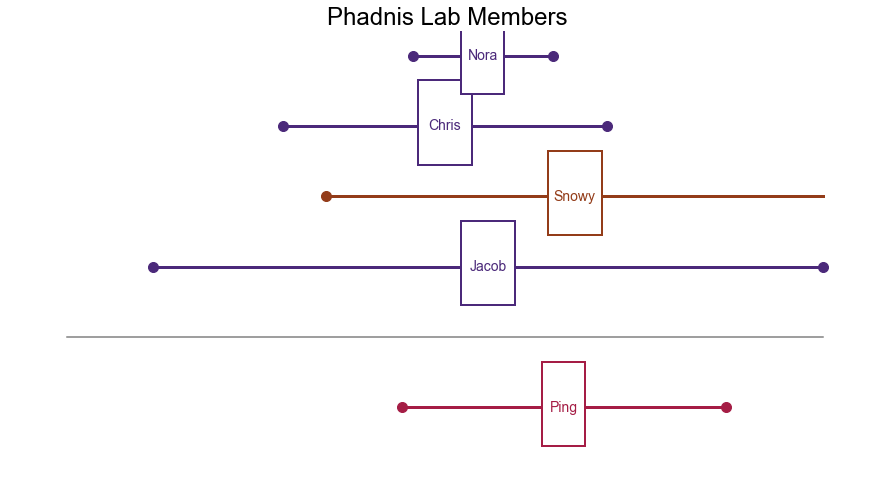

In [7]:
plt.rcParams['figure.figsize'] = (15, 8.0)

fig,ax = plt.subplots()
ax.plot((0,max_months), (0,0), color = 'grey')

# csfont = {'fontname':'Comic Sans MS'}
titlefont = {'fontname':'Arial'}
namefont = {'fontname':'Arial'}

# for each entry plot these things
for idx in range(len(dates)):
    row = dates.iloc[idx]
    
    # line
    ax.plot((row['start_num'],row['end_num']), 
             (row['ycoord'], row['ycoord']), 
             color=row['color'],
             linewidth=3.0,
             zorder=1)
    
    # end points
    ax.scatter(row['start_num'], row['ycoord'], color=row['color'], s=100, zorder=1)
    if not pd.isnull(row['end']):
        ax.scatter(row['end_num'], row['ycoord'], color=row['color'], s=100, zorder=1)
    
    # text
    mid = row['start_num'] + ((row['end_num'] - row['start_num']) / 2)

    rect = patches.Rectangle((mid-(len(row['f_name'])/2),row['ycoord']-1.1),
                             len(row['f_name']),
                             2.4,
                             linewidth=2,
                             fill=True,
                             edgecolor=row['color'],
                             facecolor='white', 
                             zorder=2)
    
    ax.add_patch(rect)
    
    ax.text(mid, row['ycoord'], row['f_name'], 
         color=row['color'], 
         horizontalalignment='center', verticalalignment='center',
         fontsize=14, 
         zorder=3,
         **namefont)

ax.set_title('Phadnis Lab Members', fontsize = 24, **titlefont)
ax.axis('off')
plt.savefig(labname + ' ' + CURRENT_DATE + '.pdf')
plt.show()